In [1]:
import xarray as xr
from glob import glob
from datetime import datetime
import yaml
import sys
sys.path.append('../../')

import plotting

from conf.global_settings import OUTPUT_DIR
from utils.pipeline_utils.file_utils import get_date
from transformations.grid_transformation import Transformation

In [2]:
ds_name = "AMSR-2_OSI-408"
hemisphere = 'nh'
with open(f'conf/ds_configs/{ds_name}.yaml', 'r') as stream:
    config = yaml.load(stream, yaml.Loader)

# Load sample granule

In [3]:
ds_granules_dir = f'{OUTPUT_DIR}/{ds_name}/harvested_granules/'
ds_granules = glob(f'{ds_granules_dir}/**/*.nc*')
if hemisphere:
    ds_granules = [g for g in ds_granules if hemisphere in g]
sample_granule_path = ds_granules[0]
print(sample_granule_path)

/Users/marlis/Developer/ECCO/ecco_output/AMSR-2_OSI-408/harvested_granules/2024/ice_conc_nh_polstere-100_amsr2_202401041200.nc


In [4]:
filename_date_str = get_date(config['filename_date_regex'], sample_granule_path.split('/')[-1])
granule_date = datetime.strptime(filename_date_str, config['filename_date_fmt']).strftime('%Y-%m-%dT%H:%M:%SZ')
ds = xr.open_dataset(sample_granule_path)
ds

<xarray.Dataset>
Dimensions:                   (time: 1, nv: 2, xc: 760, yc: 1120)
Coordinates:
  * time                      (time) datetime64[ns] 2024-01-04T12:00:00
  * xc                        (xc) float64 -3.845e+03 -3.835e+03 ... 3.745e+03
  * yc                        (yc) float64 5.845e+03 5.835e+03 ... -5.345e+03
    lat                       (yc, xc) float32 ...
    lon                       (yc, xc) float32 ...
Dimensions without coordinates: nv
Data variables:
    Polar_Stereographic_Grid  int32 ...
    time_bnds                 (time, nv) datetime64[ns] ...
    ice_conc                  (time, yc, xc) float32 ...
    raw_ice_conc_values       (time, yc, xc) float32 ...
    status_flag               (time, yc, xc) float32 ...
    total_uncertainty         (time, yc, xc) float32 ...
    smearing_uncertainty      (time, yc, xc) float32 ...
    algorithm_uncertainty     (time, yc, xc) float32 ...
Attributes: (12/30)
    title:                   Level-3 Sea Ice Concentration Analysis (AMSR2) f...
    product_id:              OSI-408-a
    instrument_type:         AMSR2
    platform_name:           GCOM-W
    easternmost_longitude:   180.0
    westernmost_longitude:   -180.0
    ...                      ...
    references:              Product User Manual and Algorithm Theoretical Ba...
    history:                 Created 2024-01-05 02:00:56
    product_version:         4.1
    software_version:        2.0.4
    netcdf_version:          1.5.4
    Conventions:             CF-1.6

# Load grid

In [5]:
grids = glob(f'grids/*.nc*')
grids.sort()
f'Available grids: {grids}'

"Available grids: ['grids/ECCO_llc270.nc', 'grids/ECCO_llc90.nc', 'grids/TPOSE.nc', 'grids/polar_stereo_n_25km.nc']"

In [6]:
grid_ds = xr.open_dataset(grids[3])
grid_ds

<xarray.Dataset>
Dimensions:                (j: 448, i: 304)
Coordinates:
  * j                      (j) int16 0 1 2 3 4 5 6 ... 442 443 444 445 446 447
  * i                      (i) int16 0 1 2 3 4 5 6 ... 298 299 300 301 302 303
Data variables:
    XC                     (j, i) float32 ...
    YC                     (j, i) float32 ...
    effective_grid_radius  (j, i) float32 ...
Attributes:
    name:                  polar_stereo_n_25km_demo
    type:                  latlon
    geospatial_lat_min:    31.102673
    geospatial_lat_max:    89.836815
    geospatial_lon_min:    -180.0
    geospatial_lon_max:    179.81398
    geospatial_lat_units:  degrees_north
    geospatial_lon_units:  degrees_east

In [7]:
T = Transformation(config, sample_granule_path, granule_date)

# Make mapping factors

In [8]:
factors = T.make_factors(grid_ds)

# Transformation

In [9]:
field_ds_list = T.transform(grid_ds, factors, ds)

Transformation failed: key confidence_level is missing from source data. Making empty record.


In [10]:
field_ds = field_ds_list[0][0]
field_ds

<xarray.Dataset>
Dimensions:                                            (time: 1, j: 448,
                                                        i: 304, nv: 2)
Coordinates:
  * time                                               (time) datetime64[ns] ...
  * j                                                  (j) int16 0 1 ... 446 447
  * i                                                  (i) int16 0 1 ... 302 303
    XC                                                 (j, i) float32 168.3 ....
    YC                                                 (j, i) float32 31.1 .....
    time_bnds                                          (time, nv) datetime64[ns] ...
Dimensions without coordinates: nv
Data variables:
    ice_conc_interpolated_to_polar_stereo_n_25km_demo  (time, j, i) float64 0...
Attributes:
    interpolated_grid:            polar_stereo_n_25km_demo
    model_grid_type:              latlon
    original_dataset_title:       Global Sea Ice Concentration (AMSR-2)
    original_dataset_short_name:  Global Sea Ice Concentration (AMSR-2)
    original_dataset_url:         https://osi-saf.eumetsat.int/products/osi-408
    original_dataset_reference:   https://osisaf-hl.met.no/sites/osisaf-hl.me...
    original_dataset_doi:         OSI-408
    interpolated_grid_id:         polar_stereo_n_25km_demo
    transformation_version:       2.0
    notes:

# Visualization

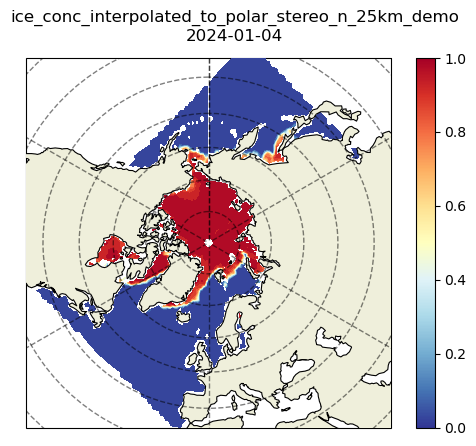

/Users/marlis/opt/anaconda3/envs/ecco_pipeline/lib/python3.10/site-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Users/marlis/opt/anaconda3/envs/ecco_pipeline/lib/python3.10/site-packages/matplotlib/contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


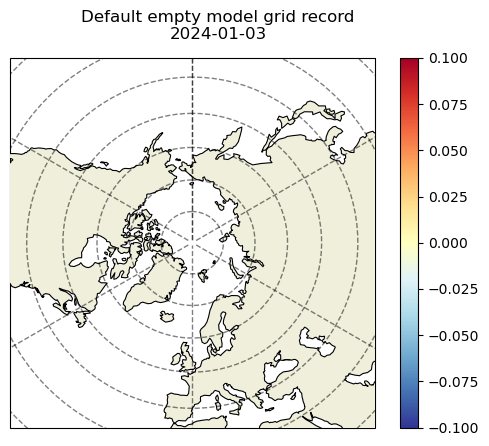

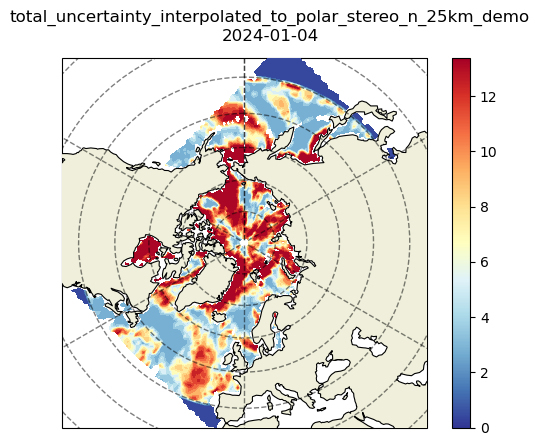

In [11]:
for field_ds in field_ds_list:
    plotting.make_plot(field_ds[0][list(field_ds[0].data_vars)[0]], 'nh')
